### Классификация изображений художников разного стиля с использованием `PyTorch`

Импорт библиотек:

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
#import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Определяем трансформацию изображений: отдельно для тренировочного набора с аугментацией данных и отдельно для тестового и валидационного.

In [2]:
# define default transormation

val_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# randop crop
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
#     transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomRotation(30),
    #transforms.GaussianNoise(0.1),

    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #transforms.Normalize()
    #transforms.Normalize(mean, std)

])

Загрузка изображений, которые хранятся в директории `images` 

In [3]:
image_dataset = torchvision.datasets.ImageFolder('images', transform=val_transform)

Разбиваем изображения на трейновый, валидационный и тестовый набор (70%, 20%, 10%) без стратификации. Оказалось, что это работает хуже чем со стратификацией с учетом размеров классов 

In [4]:
# train_size = int(0.7 * len(image_dataset))
# val_size = int(0.2 * len(image_dataset))
# test_size = len(image_dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size, test_size])
# # realize data augmentation for train set
# train_dataset.dataset.transform = train_transform


In [5]:
# print("Train set size: {:}, validation set size: {:}, test set size: {:}".format(train_size, val_size, test_size))

# print(train_size)
# print(val_size)
# print(test_size)
# print(train_dataset.dataset)

In [6]:
# загрузка данных соответствующего размера
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Разбиваем изображения на трейновый, валидационный и тестовый набор с учетом размеров классов.

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the labels for each image
labels = [image_dataset[i][1] for i in range(len(image_dataset))]

# Create the stratified shuffle split object
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3)

# Split the indices of the images into train and validation-test sets
for train_index, test_valid_index in split.split(range(len(image_dataset)), labels):
    train_dataset = torch.utils.data.Subset(image_dataset, train_index)
    test_valid_dataset = torch.utils.data.Subset(image_dataset, test_valid_index)

# Create a second stratified shuffle split object for the train set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4)

# Split the indices of the train set into train and validation sets
for val_index, test_index in split.split(range(len(test_valid_dataset)), [test_valid_dataset[i][1] for i in range(len(test_valid_dataset))]):
    test_dataset = torch.utils.data.Subset(test_valid_dataset, test_index)
    val_dataset = torch.utils.data.Subset(test_valid_dataset, val_index)


In [8]:
# загрузка данных соответствующего размера
train_dataset.dataset.transform = train_transform
print(train_dataset.dataset)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Dataset ImageFolder
    Number of datapoints: 1422
    Root location: images
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [9]:
print("Train set size: {:}, validation set size: {:}, test set size: {:}".format(train_index.size, val_index.size, test_index.size))

Train set size: 995, validation set size: 256, test set size: 171


Проверим результат разбиения по классам

In [10]:
def count_classes(dataloader):
    labels_count = defaultdict(int)
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        for label in labels:
            labels_count[label.item()] += 1
    return(labels_count)

data = {'Train set': count_classes(train_dataloader),
        'Validation set': count_classes(val_dataloader),
        'Test set': count_classes(test_dataloader)}
print(data)

{'Train set': defaultdict(<class 'int'>, {7: 97, 2: 168, 6: 52, 3: 142, 4: 153, 5: 82, 1: 255, 0: 46}), 'Validation set': defaultdict(<class 'int'>, {3: 37, 2: 43, 1: 66, 6: 14, 7: 25, 4: 39, 0: 11, 5: 21}), 'Test set': defaultdict(<class 'int'>, {3: 24, 2: 29, 0: 8, 7: 17, 4: 26, 5: 14, 1: 44, 6: 9})}


In [11]:
for i, group in enumerate(data.keys()):
    print(group)
    keys = list(data[group].keys())
    print(keys)
    print(list(data[group].values()))

Train set
[7, 2, 6, 3, 4, 5, 1, 0]
[97, 168, 52, 142, 153, 82, 255, 46]
Validation set
[3, 2, 1, 6, 7, 4, 0, 5]
[37, 43, 66, 14, 25, 39, 11, 21]
Test set
[3, 2, 0, 7, 4, 5, 1, 6]
[24, 29, 8, 17, 26, 14, 44, 9]


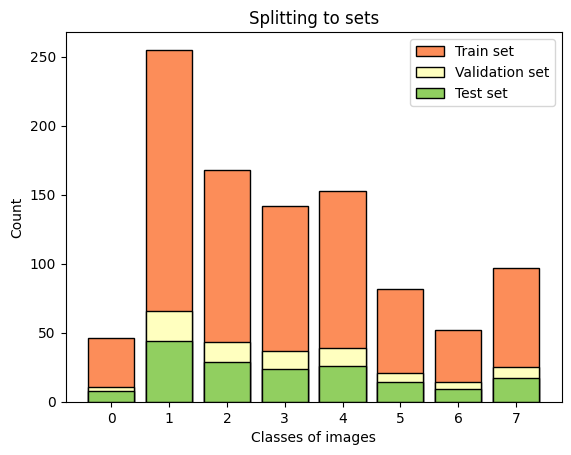

In [12]:
colors = ['#fc8d59', '#ffffbf', '#91cf60']

for i, group in enumerate(data.keys()):
    keys = list(data[group].keys())
    values = list(data[group].values())
    plt.bar(keys, values, edgecolor='black', color=colors[i], label=group)

plt.xlabel('Classes of images')
plt.ylabel('Count')
plt.title('Splitting to sets')
plt.legend()
plt.show()

Определяем модель для классификации изображений: resnet с 18 слоями, задаем на полносвязном уровне количество наших классов 

In [46]:
model = torchvision.models.resnet18(weights=True)
#model = torchvision.models.resnet50(weights=True)

model.fc = nn.Linear(512, len(image_dataset.classes))
model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.2, training=m.training))
#model.fc.register_forward_hook(lambda m, inp, out: nn.Softmax(out))
#model.fc = nn.Sequential(
 #   nn.Linear(512, len(image_dataset.classes)),
  #  nn.Softmax())
#model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.2, training=m.training))


C:\Users\elena\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# from torchvision.models.feature_extraction import get_graph_node_names
# from torchvision.models import resnet50

# train_nodes, eval_nodes = get_graph_node_names(resnet50())
# print(train_nodes)
# print(eval_nodes)

Выбираю функцию ошибки CrossEntropyLoss, поскольку у нас задача классификации нескольких классов. Стохастический градиентный спуск показал самый лучший результат в этой задаче


In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters())
# optimizer = optim.RMSprop(model.parameters()) # this optimizer functioned really bad

In [48]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

Задаем функцию для проверки валидационного и тестого сета, чтобы не дублировать код

In [49]:
def validate(curr_model, dataloader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            outputs = curr_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_loss = running_loss / len(dataloader)
        val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [50]:
num_epochs = 1
best_accuracy = 0
best_loss = float('inf')
best_epoch = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Record the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate the average loss and accuracy for the epoch
    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validate the model
    val_loss, val_accuracy = validate(model, val_dataloader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print("Epoch {}/{} - Train Loss: {:.4f} - Train Accuracy: {:.2f}% - Val Loss: {:.4f} - Val Accuracy: {:.2f}%".format(
        epoch + 1, num_epochs, train_loss, train_accuracy, val_loss, val_accuracy))
    if val_accuracy > best_accuracy or (val_accuracy == best_accuracy and val_loss < best_loss):
        best_accuracy = val_accuracy
        best_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

Epoch 1/1 - Train Loss: 2.1035 - Train Accuracy: 24.72% - Val Loss: 1.7657 - Val Accuracy: 34.77%


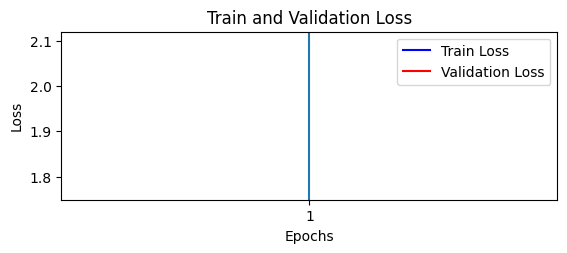

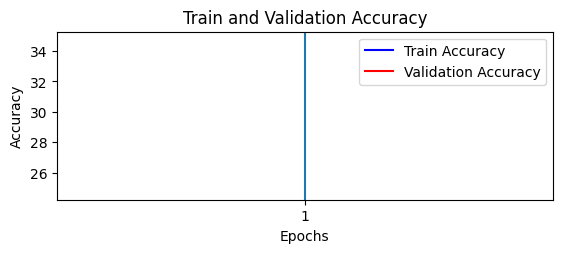

In [51]:
epochs = range(1, num_epochs + 1)
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs+1))
plt.legend()
plt.axvline(x = best_epoch+1, linestyle = '-')
plt.show()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xticks(range(1, num_epochs+1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.axvline(x = best_epoch+1, linestyle = '-')
plt.show()


#plt.plt(train_losses, val_losses)

In [20]:
# plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
# plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
# plt.title('Train and Validation Accuracy')
# plt.xticks(range(1, num_epochs+1))
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [52]:
# best_model = models.resnet.ResNet(...)
model.load_state_dict(torch.load('best_model.pt'))
# print(model)
test_loss, test_accuracy = validate(model, test_dataloader, criterion)
print(best_epoch+1)
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}% in the epoch {:}".format(test_loss, test_accuracy, best_epoch+1))

1
Test Loss: 1.7663, Test Accuracy: 35.67% in the epoch 1


In [22]:
# print(model)
# type(best_model)
# type(model)
# print(best_model.__class_)

Почему использовали F1 score взвешенный

In [53]:
# Initialize the confusion matrix

confusion_matrix = torch.zeros(len(image_dataset.classes), len(image_dataset.classes), dtype=torch.int64)

# Initialize the lists to store the true labels and predicted labels for the test set
true_labels = []
pred_labels = []

# Evaluation mode
model.eval()

# Set the gradient computation to be off
with torch.no_grad():
    # Iterate over the test data
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        
        # Append the true labels and predicted labels to the lists
        true_labels.extend(labels.tolist())
        pred_labels.extend(preds.tolist())
        
        # Increment the count in the corresponding cells of the confusion matrix
        for t, p in zip(labels, preds):
            confusion_matrix[t, p] += 1

# Compute the precision, recall and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
precision_macro, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(true_labels, pred_labels, average='macro')

# Print the test loss, test accuracy and f1-score
print("Weighted Test Loss: {:.4f} - Test Accuracy: {:.2f}% - Test F1-Score: {:.2f}".format(test_loss, test_accuracy, f1_score))
print("Macro Test Loss: {:.4f} - Test Accuracy: {:.2f}% - Test F1-Score: {:.2f}".format(test_loss, test_accuracy, f1_score_macro))

Weighted Test Loss: 1.7663 - Test Accuracy: 35.67% - Test F1-Score: 0.37
Macro Test Loss: 1.7663 - Test Accuracy: 35.67% - Test F1-Score: 0.31


In [54]:
confusion_matrix

tensor([[ 0,  3,  0,  0,  2,  0,  0,  3],
        [ 0, 35,  4,  4,  0,  0,  0,  1],
        [ 0,  8,  9,  2,  4,  1,  2,  3],
        [ 2,  7,  3,  6,  3,  1,  1,  1],
        [ 1,  7,  4,  4,  6,  1,  1,  2],
        [ 0,  2,  3,  1,  2,  5,  0,  1],
        [ 0,  5,  0,  0,  0,  2,  2,  0],
        [ 0,  7,  2,  0,  1,  1,  0,  6]])

In [55]:
print(precision)
print(recall)

0.3728169712070641
0.40350877192982454


In [26]:
print(train_losses)
print(train_accuracies)
print(val_losses)
print(val_accuracies)

[2.147220693528652, 1.677131962031126, 1.5340525805950165, 1.5664426162838936, 1.441852966323495, 1.294315166771412, 1.248754482716322, 1.1394465640187263, 1.161951331421733, 1.0902934055775404, 1.121062932536006, 1.0349506959319115, 1.0320556331425905, 1.0235896315425634, 0.9379386538639665, 0.9313449505716562, 0.8784885462373495, 0.8585879225283861, 0.8317494913935661, 0.752587073482573, 0.8488617409020662, 0.8173243245109916, 0.8033492686226964, 0.7828365107998252, 0.7586260056123137, 0.6681618979200721, 0.7670698277652264, 0.7179401386529207, 0.7249430613592267, 0.7541854232549667, 0.7150207376107574, 0.6826425716280937, 0.6136780236847699, 0.7268364680930972, 0.6766176586970687, 0.555357494391501, 0.5398009037598968, 0.5724689206108451, 0.6714917588979006, 0.5666353185661137, 0.6458759745582938, 0.5483591631054878, 0.5538505641743541, 0.6258427491411567, 0.540506518445909, 0.6061534313485026, 0.5643281731754541, 0.6447398830205202, 0.6153440796770155, 0.5852309353649616]
[20.0, 38